In [1]:
# %%capture
# # Export this Notebook to PDF
# !jupyter nbconvert --to pdf "Modeling.ipynb" \
#     --TagRemovePreprocessor.enabled=True  \
#     --TagRemovePreprocessor.remove_cell_tags remove_cell \
#     --TagRemovePreprocessor.remove_all_outputs_tags remove_output \
#     --TagRemovePreprocessor.remove_input_tags remove_input;

In [2]:
# Make Jupyter reload library before every execution

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')



# Data Loading and Preparation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/all.csv", parse_dates=True)

Now, we need to preprocess the data before model fitting.
(Note: this following code block is hidden in the PDF version of this notebook)

In [4]:
# Define mappings for ordinal conversion
age_mapping = {
    "25-34": 30,
    "16-24": 20,
    "35-44": 40,
    "45-54": 50,
    "55+": 60,
}

onset_mapping = {
    "<15 Minutes": 7.5,
    "30-60 Minutes": 45,
    "15-30 Minutes": 20,
    ">60 Minutes": 60,
}

nap_mapping = {
    "No Nap": 0,
    "<30 Minutes": 15,
    "60-90 Minutes": 75,
    "30-60 Minutes": 45,
    ">90 Minutes": 100,
}
exercise_mapping = {"0 Days": 0, "1-2 Days": 1, "3-4 Days": 2, "5+ Days": 3}
sleep_disturbances_mapping = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Often": 4,
}
device_usage_mapping = {
    "<1 Hour": 0,
    "1-3 Hours": 1,
    "3-5 Hours": 2,
    "5-7 Hours": 3,
    "7+ Hours": 4,
}

# Convert 'Exercise Days/Week' and 'Sleep Disturbances' from categorical to ordinal using the defined mappings
df["Age Group Ordinal"] = df["Age Group"].map(age_mapping)
df["Sleep Onset Time Ordinal"] = df["Sleep Onset Time"].map(onset_mapping)
df["Nap Duration Ordinal"] = df["Nap Duration"].map(nap_mapping)
df["Exercise Days/Week Ordinal"] = df["Exercise Days/Week"].map(exercise_mapping)
df["Sleep Disturbances Ordinal"] = df["Sleep Disturbances"].map(
    sleep_disturbances_mapping
)
df["Device Usage (hrs/day) Ordinal"] = df["Device Usage (hrs/day)"].map(
    device_usage_mapping
)

# Select only numerical columns for covariance calculation
numerical_df = df.select_dtypes(include=["number"]).drop(
    ["Height (cm)", "Weight (kg)"], axis=1
)

from sklearn.model_selection import train_test_split

# Preparing the data for modeling
X = df[['Nap Duration Ordinal', 'Exercise Days/Week Ordinal', 'Sleep Disturbances Ordinal', 'Age Group Ordinal']]
y = df['Calculated Night Sleep Duration']

# Handling any potential missing values
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)xw

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Predicting Night Sleep Duration (Regression)

## Linear Regression

In [5]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Creating the linear regression model
model = LinearRegression()

# Fitting the model on the training data
model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the model coefficients and performance metrics
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Model Coefficients: [-0.01698294  0.15863872 -0.0161974  -0.05333599]
Intercept: 8.824117620374018
Mean Squared Error: 1.3388887030966372
R^2 Score: 0.24568772503605862


* **Model Coefficients:**
These values represent the estimated effect of each independent variable on the dependent variable (sleep duration), holding all other variables constant.
The coefficients [-0.0169824, 0.15863872, -0.0161974, -0.05333599] correspond to the variables in the order they were input into the model. If we assume the order was ['Nap Duration Ordinal', 'Exercise Days/Week Ordinal', 'Sleep Disturbances Ordinal', 'Age Group * Ordinal'], then:
For every unit increase in 'Nap Duration Ordinal', sleep duration decreases by 0.0169824 units, holding other variables constant.
For every unit increase in 'Exercise Days/Week Ordinal', sleep duration increases by 0.15863872 units, holding other variables constant.
For every unit increase in 'Sleep Disturbances Ordinal', sleep duration decreases by 0.0161974 units, holding other variables constant.
For every unit increase in 'Age Group Ordinal', sleep duration decreases by 0.05333599 units, holding other variables constant.
* **Intercept:**
The value 8.824117620374018 is the expected mean value of the dependent variable (sleep duration) when all predictors are held at zero. In the context of this model, it represents the estimated sleep duration for an individual with the baseline levels of the ordinal predictors.
* **Mean Squared Error (MSE):**
The MSE value of 1.3388887030966368 is the average of the squares of the errors, i.e., the average squared difference between the estimated values and the actual value of the dependent variable. A lower MSE indicates a better fit of the model to the data.
* **R² Score:**
The R² value of 0.24568772530605874 indicates that approximately 24.57% of the variability in sleep duration can be explained by the model. An R² score of 1 indicates a perfect fit, so a score of 0.2457 suggests that while there is some relationship, a substantial amount of the variability in sleep duration remains unexplained by the model.

In summary, the model indicates that exercise frequency has a positive association with sleep duration, while nap duration, sleep disturbances, and age group have negative associations. However, the model does not explain a large portion of the variability in sleep duration, suggesting that other factors not included in the model may also be important.

## Decision Tree Regressor

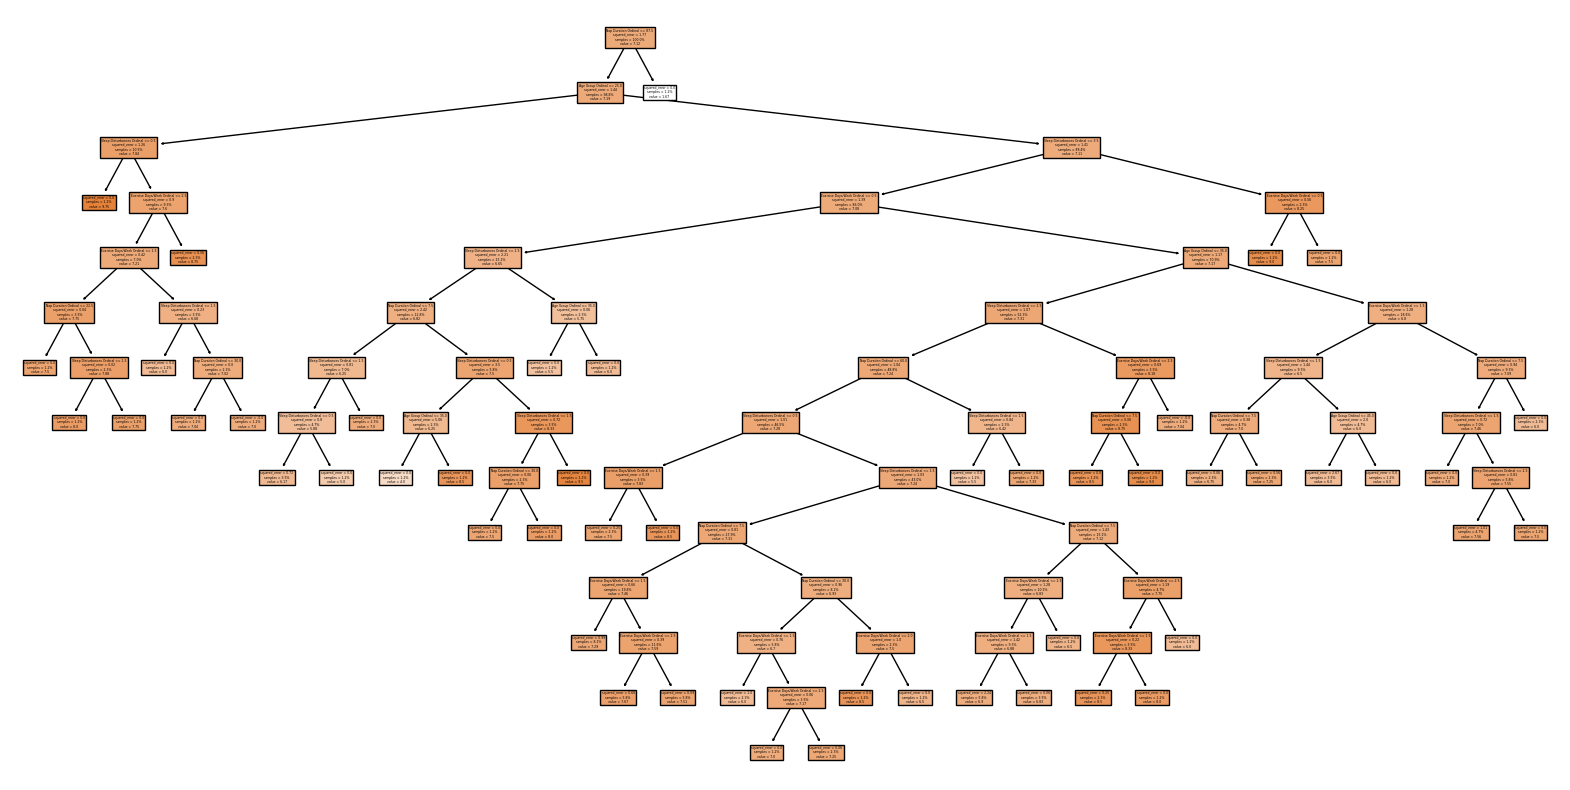

Decision Tree Mean Squared Error: 3.4191670270047414
Decision Tree R^2 Score: -0.9263137052815129


In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree


# Create the Decision Tree model
decision_tree_model = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
decision_tree_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_tree = decision_tree_model.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, filled=True, feature_names=X.columns.tolist(), proportion=True, precision=2)
plt.show()

# Output the performance metrics
print("Decision Tree Mean Squared Error:", mse_tree)
print("Decision Tree R^2 Score:", r2_tree)

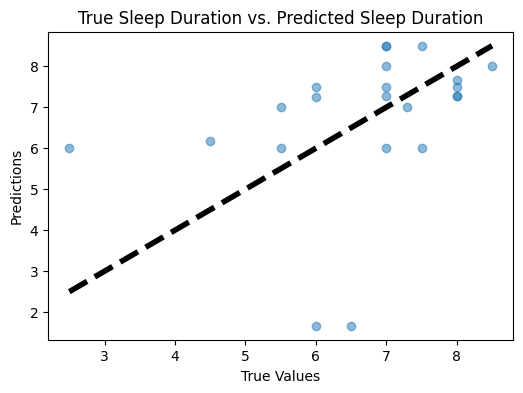

In [8]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_tree, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Sleep Duration vs. Predicted Sleep Duration')
plt.show()

The decision tree model has a significantly higher MSE than the linear regression model. This indicates that on average, the decision tree model's predictions are further from the true sleep duration values than the linear regression model's predictions.
The R² score for the decision tree model is negative, which suggests that it performs worse than a simple horizontal line at the mean of the sleep duration. In contrast, the linear regression model had a positive R² value, indicating that it was able to explain about 24.6% of the variance in sleep duration.

**Conclusion:**

The linear regression model appears to be a better fit for the data compared to the decision tree model. It has a lower average error in predictions and a positive R² value, which means it can account for a certain proportion of the variance in sleep duration. In contrast, the decision tree model's negative R² score indicates that it may be overfitting the training data or not capturing the complexity of the relationship adequately. 

## K-Nearest Neighbor Regression

In [9]:
from sklearn.neighbors import KNeighborsRegressor

# Create the KNN regressor model, using n_neighbors=5 as a starting point
knn_model = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
knn_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Output the performance metrics
print("KNN Regressor Mean Squared Error:", mse_knn)
print("KNN Regressor R^2 Score:", r2_knn)

KNN Regressor Mean Squared Error: 1.6240662402638626
KNN Regressor R^2 Score: 0.08502245365711447


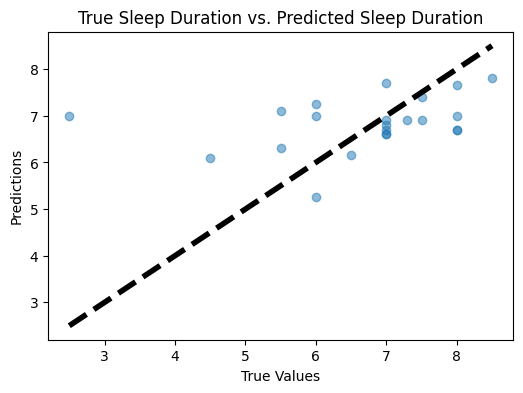

In [10]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Sleep Duration vs. Predicted Sleep Duration')
plt.show()

* **Mean Squared Error (MSE):** The MSE is approximately 1.624. This value indicates the average squared difference between the actual and predicted sleep durations. Compared to the decision tree model, which had a much higher MSE, the KNN regressor has reduced the average error in predictions, but it is still higher than what we observed with the linear regression model.

* **R² Score:** The R² score is approximately 0.085. This value indicates that the KNN model explains about 8.5% of the variance in sleep duration. It is a positive score, which is an improvement over the decision tree model (which had a negative R² score), but it is significantly lower than the R² score from the linear regression model, which was approximately 0.246.

* **Interpretation:** The KNN regressor's performance is not as strong as the linear regression model but is better than the decision tree model based on these metrics. The relatively low R² score from the KNN regressor suggests that while the model captures some of the variability in sleep duration, a large portion of the variance remains unexplained by the model.

**Conclusion:**

In summary, while the KNN regressor has shown some predictive capabilities, its performance is not yet optimal compared to the linear regression model for this particular dataset.

## Support Vector Machine

In [11]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Standardize the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the SVM regressor model
svm_model = SVR()

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

# Output the performance metrics
print("SVM Regressor Mean Squared Error:", mse_svm)
print("SVM Regressor R^2 Score:", r2_svm)

SVM Regressor Mean Squared Error: 1.5909012929685098
SVM Regressor R^2 Score: 0.10370714849810991


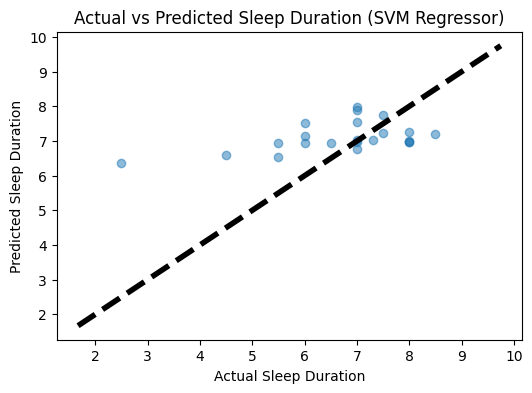

In [12]:

# Visualization
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_svm, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual Sleep Duration')
plt.ylabel('Predicted Sleep Duration')
plt.title('Actual vs Predicted Sleep Duration (SVM Regressor)')
plt.show()

* **Mean Squared Error (MSE):** The MSE is approximately 1.591, indicating the average squared difference between the observed actual and the model's predicted sleep durations. This value reflects the model's prediction error; the closer the MSE is to 0, the better the model's predictive accuracy.

* **R² Score:** The R² score is approximately 0.104, which means that the SVM model explains about 10.37% of the variance in sleep duration. The R² score is a measure of how well the observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model.

* **Interpretation:**
The SVM model's MSE is slightly higher than the linear regression model's MSE but lower than the decision tree's MSE, placing its predictive accuracy between the two. The positive R² score indicates that the SVM model has captured some of the variance in the target variable, albeit a small portion.

**Conclusion:**

While the SVM model shows some predictive ability, its performance is modest, as it explains just over 10% of the variance in sleep duration. This suggests that the model, with its current configuration, captures only a fraction of the factors affecting sleep duration. There may be room for improvement through hyperparameter tuning, feature engineering, or trying different kernel functions within the SVM framework to potentially enhance model performance.

# Predicting Sleep Quality (Classification)

## Multiclass Logistic Regression

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.25      0.10      0.14        10
           4       0.40      0.60      0.48        10
           5       0.00      0.00      0.00         1

    accuracy                           0.32        22
   macro avg       0.16      0.17      0.16        22
weighted avg       0.30      0.32      0.28        22



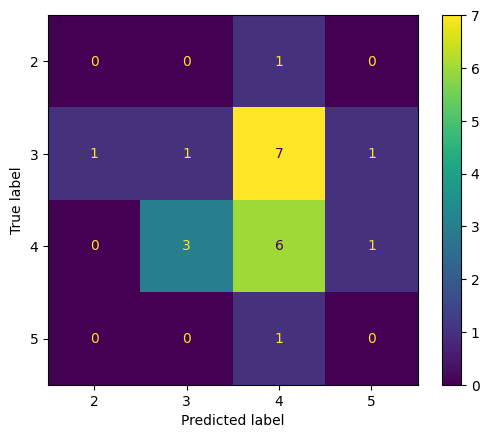

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Selecting predictors and the binary target variable
X = df[['Nap Duration Ordinal', 'Exercise Days/Week Ordinal', 'Sleep Disturbances Ordinal', 'Age Group Ordinal']]
y = df['Sleep Quality']

# Fill any missing values
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Logistic Regression model
logistic_model = LogisticRegression()

# Fit the model on the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_logistic))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_logistic, labels=logistic_model.classes_)
ConfusionMatrixDisplay(cm, display_labels=logistic_model.classes_).plot()
plt.show()

**Classification Report Analysis**:

- Classes 2 and 5 have no instances correctly predicted (precision and recall are 0.00), indicating the model failed to identify these categories.
- Class 4 has the highest precision (0.40) and recall (0.60), which means it was the most accurately predicted class.
- The overall accuracy of the model is 0.32, meaning it correctly predicts the sleep quality 32% of the time.
- Macro average precision, recall, and F1-score are low (around 0.16), indicating poor performance across all classes.
- The weighted average is slightly better due to class imbalance (more samples in some classes than others).

**Confusion Matrix Analysis**:

- The confusion matrix visualizes the actual vs. predicted classifications. The matrix shows that class 3 had the most samples (10), with 7 being correctly predicted.
- Class 4 had 10 samples as well, with 6 being correctly predicted and some misclassifications into class 3.
- There were only one sample each for classes 2 and 5, and the model misclassified both. Class 2 was predicted as class 3, and class 5 was predicted as class 4.
- The diagonal (from top-left to bottom-right) shows the number of correct predictions for each class. Values off the diagonal represent misclassified instances.

**Conclusions**:

- The model is not very effective at distinguishing between all the classes of sleep quality, particularly struggling with the least represented classes.
- Classes with more data points (like 3 and 4) were predicted with more accuracy, suggesting that the model may require more balanced data or class weights to perform better across all categories.
- Improvements could include collecting more data, especially for underrepresented classes, feature engineering, or trying different classification algorithms that may handle multi-class problems better.

## Decision Tree Classifier

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.83      0.50      0.62        10
           4       0.78      0.70      0.74        10
           5       0.00      0.00      0.00         1

    accuracy                           0.55        22
   macro avg       0.40      0.30      0.34        22
weighted avg       0.73      0.55      0.62        22



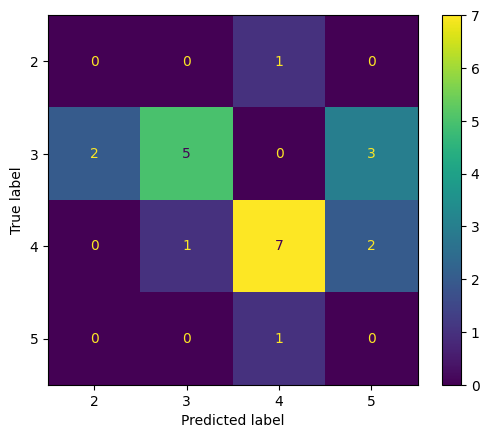

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Decision Tree Classifier model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
decision_tree_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_decision_tree = decision_tree_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_decision_tree))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_decision_tree, labels=decision_tree_model.classes_)
ConfusionMatrixDisplay(cm, display_labels=decision_tree_model.classes_).plot()
plt.show()

**Classification Report:**

- The precision for class 3 is high at 0.83, suggesting that when the model predicts class 3, it is correct 83% of the time.
- The recall for class 4 is 0.70, indicating that the model correctly identifies 70% of all class 4 instances.
- The F1-score, which balances precision and recall, is highest for class 4 at 0.74, suggesting a relatively better performance for this class.
- The accuracy of the decision tree model is 0.55, meaning it correctly predicts 55% of the instances.
- The weighted average F1-score is 0.62, which is influenced by the number of instances in each class.

**Confusion Matrix:**

- The confusion matrix shows the number of predictions for each class. For instance, 7 out of 10 instances of class 4 were correctly predicted.
- There are misclassifications, notably with 2 instances of class 3 and 3 instances of class 4 being misclassified.

**Comparison to Linear Model:**

- We can note that the decision tree's accuracy of 0.55 is an improvement over the linear model's accuracy of 0.32, based on the earlier provided analysis.
- The weighted F1-score is also higher for the decision tree model (0.62) compared to the linear model's score of 0.28, suggesting a better balance of precision and recall for the decision tree.
- The decision tree model seems to have a better ability to distinguish between some classes compared to the linear model, as reflected in the higher precision and recall values for certain classes.

**Conclusion:**

The decision tree model outperforms the linear model in terms of accuracy and F1-score. However, there are still misclassifications, and the model's performance varies across different classes. It's also important to note that the decision tree may be more prone to overfitting, and the improved performance might not generalize to unseen data. It would be beneficial to validate these results with cross-validation or on a separate test set.

## Random Forest

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.83      0.50      0.62        10
           4       0.78      0.70      0.74        10
           5       0.00      0.00      0.00         1

    accuracy                           0.55        22
   macro avg       0.40      0.30      0.34        22
weighted avg       0.73      0.55      0.62        22



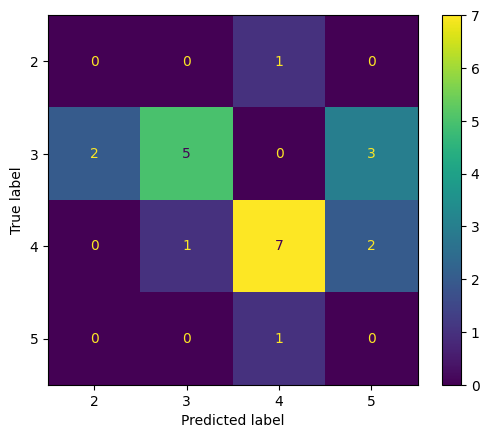

In [15]:
from sklearn.ensemble import RandomForestClassifier


# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred_rf))

# Compute and plot the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_classifier.classes_)
ConfusionMatrixDisplay(cm_rf, display_labels=rf_classifier.classes_).plot()
plt.show()

**Random Forest Model Analysis**:

- The model completely misses classes 2 and 5, as indicated by the zero precision and recall.
- Class 3 is predicted with high precision (0.83), but the recall (0.50) suggests only half the actual class 3 instances are captured.
- Class 4 is the best-predicted category with a solid F1-score of 0.74.
- The overall accuracy stands at 0.55, and the weighted average F1-score is 0.62, factoring in the varying class sizes.

**Comparison to Other Models**:

- **Accuracy**:
 The Random Forest model shows a marked improvement with an accuracy of 0.55 over the linear model's 0.32. It matches the decision tree model's accuracy, also at 0.55.
- **Weighted F1-Score**:
 At 0.62, the Random Forest model indicates a better performance across classes compared to the linear model's 0.28 and is on par with the decision tree model.
- **Class Prediction**:
 Like the decision tree, the Random Forest model effectively predicts class 4, indicating that tree-based models may handle certain features better in this dataset. Both models surpass the linear model in predicting this class.
- **Minority Classes**:
 The Random Forest and decision tree models struggle with minority classes (2 and 5), similar to the linear model. This is a common issue in imbalanced datasets.

**Conclusive Remarks**:

The Random Forest model has demonstrated comparable performance to the decision tree model and superior performance to the linear model. Its strength lies in handling complex relationships that linear models may not capture. However, like the decision tree, it still fails to address the imbalance effectively, missing the minority classes. To enhance the predictive ability across all classes, techniques like class weighting, data resampling, or gathering more data for underrepresented classes could be explored.


## K-Nearest Neighbor Classification

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.67      0.20      0.31        10
           4       0.60      0.90      0.72        10
           5       0.00      0.00      0.00         1

    accuracy                           0.50        22
   macro avg       0.32      0.28      0.26        22
weighted avg       0.58      0.50      0.47        22



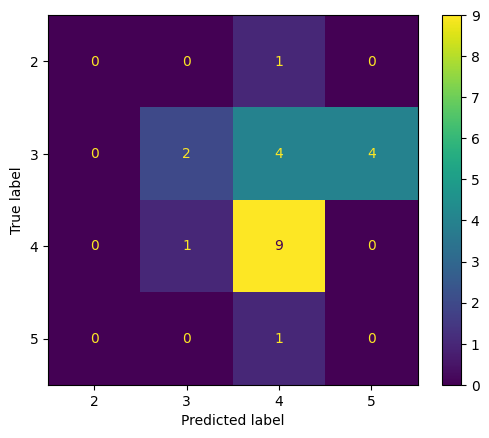

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Handle missing values
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True)  # Assuming 'Sleep Quality' is categorical and replacing NaNs with the mode

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN classifier with a specified number of neighbors, let's start with k=5
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred_knn))

# Compute and plot the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=knn_classifier.classes_)
ConfusionMatrixDisplay(cm_knn, display_labels=knn_classifier.classes_).plot()
plt.show()


**KNN Model Analysis**:

- Classes 2 and 5 were not predicted correctly at all, as shown by the precision and recall scores of 0.00.
- Class 4 is predicted with a high recall of 0.90, indicating the model successfully identified 90% of the actual class 4 instances.
- The precision for class 3 is 0.67, meaning that when the model predicts class 3, it is correct two-thirds of the time.
- The model achieves an overall accuracy of 0.50, signifying that half of the model's predictions are correct.
- The weighted average F1-score is 0.47, reflecting the model's performance across different classes, weighted by their representation in the dataset.

**Comparison to Other Models**:

- **Accuracy**: The KNN model has better accuracy (0.50) than the linear model (0.32) but is slightly lower than the decision tree 
and Random Forest models (both at 0.55).
- **Weighted F1-Score**: The KNN's weighted F1-score (0.47) is an improvement over the linear model's score (0.28) but does not 
reach the level of the decision tree and Random Forest models (both at 0.62).
- **Class Prediction**: Similar to the tree-based models, the KNN model performs well in predicting class 4 but does not do as well 
for class 3 compared to the Random Forest model, which had a precision of 0.83.
- **Minority Classes**: Like the other models, the KNN model fails to effectively classify minority classes (2 and 5).


**Conclusive Remarks**:

The KNN model stands between the other models in terms of predictive performance. It struggles with minority classes, a common issue not fully resolved by any of the tested models. The results suggest potential improvements for the KNN model through hyperparameter tuning and possibly more balanced training data, highlighting the difficulty of predicting sleep quality across imbalanced classes.


## SVM

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       1.00      0.30      0.46        10
           4       0.53      1.00      0.69        10
           5       0.00      0.00      0.00         1

    accuracy                           0.59        22
   macro avg       0.38      0.33      0.29        22
weighted avg       0.69      0.59      0.52        22



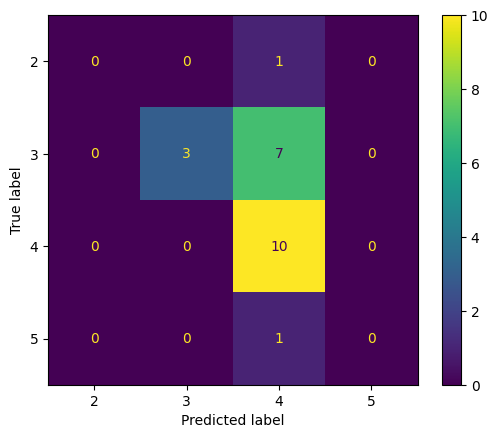

In [17]:
from sklearn.svm import SVC

# Fill any missing values
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True)  # Filling missing values in a categorical variable with its mode

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Support Vector Machine classifier model
svm_model = SVC(probability=True)  # Enable probability estimate for multi-class classification

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_svm))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)
ConfusionMatrixDisplay(cm, display_labels=svm_model.classes_).plot()
plt.show()

The image presents the classification report and confusion matrix for an SVM (Support Vector Machine) model used for predicting sleep quality.

**SVM Model Analysis**:

- The model does not correctly predict classes 2 and 5, as reflected by the precision and recall scores of 0.00.
- Class 3 has a perfect precision score of 1.00, meaning that every prediction the model made for class 3 was correct; however, its recall is 0.30, indicating it only identified 30% of the actual class 3 instances.
- Class 4 has the highest recall of 1.00, indicating that the model identified all instances of class 4 correctly, and a precision of 0.53, suggesting that around half the predictions made for class 4 were correct.
- The overall accuracy of the SVM model is 0.59, which is an improvement over the linear and KNN models' accuracies.
- The weighted average F1-score is 0.52, which is higher than the linear and KNN models' scores but lower than the Random Forest and decision tree models.

**Confusion Matrix for SVM Model**:

- Class 4 is predicted with the highest number of correct predictions (10 out of 10 instances), showing the model performs exceptionally well for this class.
- The confusion matrix shows some misclassifications, particularly class 3 instances being predicted as class 4.

**Comparison to Other Models**:

- **Accuracy**:
 The SVM model's accuracy (0.59) is higher than the linear model's (0.32) and the KNN model's (0.50), and it is on par with the decision tree and Random Forest models (both at 0.55).
- **Weighted F1-Score**:
 The SVM's weighted F1-score (0.52) is an improvement over the linear model (0.28) and the KNN model (0.47) but does not reach the level of the decision tree and Random Forest models (both at 0.62).
- **Class Prediction**:
 The SVM model is consistent with the other models in effectively predicting class 4 but outperforms the linear and KNN models in class 3 precision.

**Conclusive Remarks**:

The SVM model shows a competitive performance compared to the other models, particularly in its ability to predict class 4 with high accuracy and precision for class 3. However, like the other models, it struggles with minority classes, failing to predict classes 2 and 5 correctly. This model, like the others, may benefit from strategies to address class imbalance and improve overall predictive performance.


# Conclusion

# Conclusion

## Regression Models

### Summary Table of Results

| Model                  | Mean Squared Error | $R^2$ Score  | Interpretation                                          |
|------------------------|--------------------|------------|---------------------------------------------------------|
| Linear Regression      | 1.3389             | 0.2457     | Explains ~24.57% of the variance; some variables have negative associations with the target. |
| Decision Tree Regressor| 3.4192             | -0.9263    | Performs worse than a simple mean model; likely overfitting. |
| K-Nearest Neighbors    | 1.6241             | 0.0850     | Explains ~8.5% of the variance; better than decision tree but worse than linear regression. |
| Support Vector Machine | 1.5909             | 0.1037     | Explains ~10.37% of the variance; modest performance between decision tree and linear regression. |

### Model Comparison

- **Linear Regression** shows the lowest error and a modest $R^2$ score, indicating a decent model fit.
- **Decision Tree Regressor** has the highest error and a negative $R^2$ score, suggesting overfitting and poor predictive performance.
- **K-Nearest Neighbors** and **Support Vector Machine** have similar errors but still higher than Linear Regression. These models capture a small portion of variance compared to Linear Regression.

## Classification Models

### Summary Table of Results

| Model                        | Accuracy | Weighted Avg F1-Score | Class Prediction Performance         |
|------------------------------|----------|-----------------------|--------------------------------------|
| Multiclass Logistic Regression| 0.32     | 0.28                  | Poor performance across all classes; some classes not predicted at all. |
| Decision Tree Classifier     | 0.55     | 0.62                  | Improved performance over logistic regression; best for class 4 but still some misclassification. |
| Random Forest                | 0.55     | 0.62                  | Comparable to the decision tree; high precision for class 3, best F1 for class 4. |
| K-Nearest Neighbors          | 0.50     | 0.47                  | Better than logistic regression; good recall for class 4 but struggles with class 3. |
| SVM                          | 0.59     | 0.52                  | Best overall accuracy; high precision for class 3 and perfect recall for class 4. |

### Model Comparison

- **Decision Tree** and **Random Forest** models achieve the same accuracy, with Random Forest having slightly better precision for class 3.
- **K-Nearest Neighbors** stands in the middle with better accuracy than logistic regression but lower than tree-based models.
- **SVM** outperforms all in terms of accuracy and shows strengths in class 3 precision and class 4 recall but, like others, struggles with minority classes.

## Final Verdict

Across regression models, the **Linear Regression** model shows a balance of low error and moderate explanation of variance, suggesting it as the preferred model for predicting night sleep duration.

For classification, **SVM** stands out with the highest accuracy and substantial class prediction capabilities, despite the common challenge of minority class prediction which is present across all models. Improvements could include more balanced data, feature engineering, and exploration of alternative algorithms or hyperparameter optimization to enhance performance.

Overall, while some models perform better than others, each has limitations that could be addressed with further data collection and model tuning.
